Name: Arijit Roy Chowdhury

Wine Quality Prediction using Multi-Class Classification

Date: 13-06-2022

Email: rc.arijit@gmail.com

# Multi Class Classification with Outlier Treatment and Multi-Collinearity Treatment

# Import Libraries

In [1]:
import time
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler   # same as preprocessing.scale(data)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn import metrics, tree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from IPython.display import Image  
from sklearn.tree import export_graphviz
from yellowbrick.classifier import ROCAUC, roc_auc
from yellowbrick.features import RadViz
import pydotplus
from urllib.request import urlopen 
from itertools import cycle
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

In [2]:
# The below random states gives the best accuracy. It's different for different models. 
# I have used a separate code snippet and varied random state in a for loop from 1 to 500 
# to obtain the value of random state that gives highest testing accuracy. 

rdt = 289 
rrf = 289
rknn = 101
rsvm = 289
rlr = 289
rnb = 101

# Read the CSV File and check it's attributes

In [3]:
# Read the CSV File. File path to be modified if executed on a different Machine / OS

df = pd.read_csv('QualityPrediction.csv')

# Check the column names
col_list = list(df.columns)
print(col_list)

# There are 11 predictor variables and 1 Target variable

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [4]:
df.shape
# Insights: The dataset has 1599 rows and 12 columns

(1599, 12)

In [5]:
df.dtypes
# Insights: There are 11 float type variable columns and none of them are categorical
# The Target Variable is of Int type but it will be considered as categorical

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [6]:
# Check for Missing Data

total = df.isnull().sum()
percent = (df.isnull().sum()/df.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# Insight: There is no missing data in any of the columns

Total  Percent
fixed acidity             0      0.0
volatile acidity          0      0.0
citric acid               0      0.0
residual sugar            0      0.0
chlorides                 0      0.0
free sulfur dioxide       0      0.0
total sulfur dioxide      0      0.0
density                   0      0.0
pH                        0      0.0
sulphates                 0      0.0
alcohol                   0      0.0
quality                   0      0.0

# Outlier Check: Boxplots and Pairplots

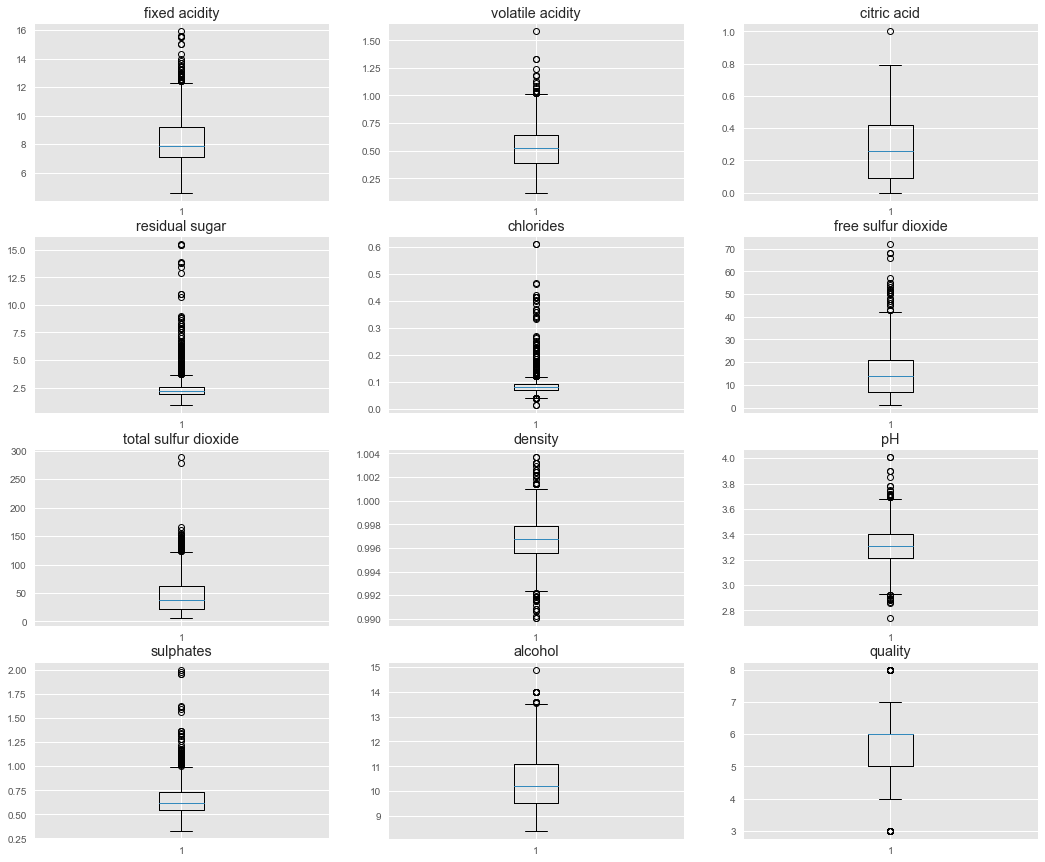

In [7]:
try:
    cols1 = list(df.columns)
    fig, ax = plt.subplots(4, 3, figsize=(18, 15))
    c = 0
    for i in range(4):
        for j in range(3):
            ax[i, j].boxplot(df[[cols1[c]]])
            ax[i, j].set_title(cols1[c])
            c=c+1
    plt.show()    
except:
    pass

# Insights on Outliers: Box Plots shows that most of the variables have outliers. Hence Outlier Treatment is necessary

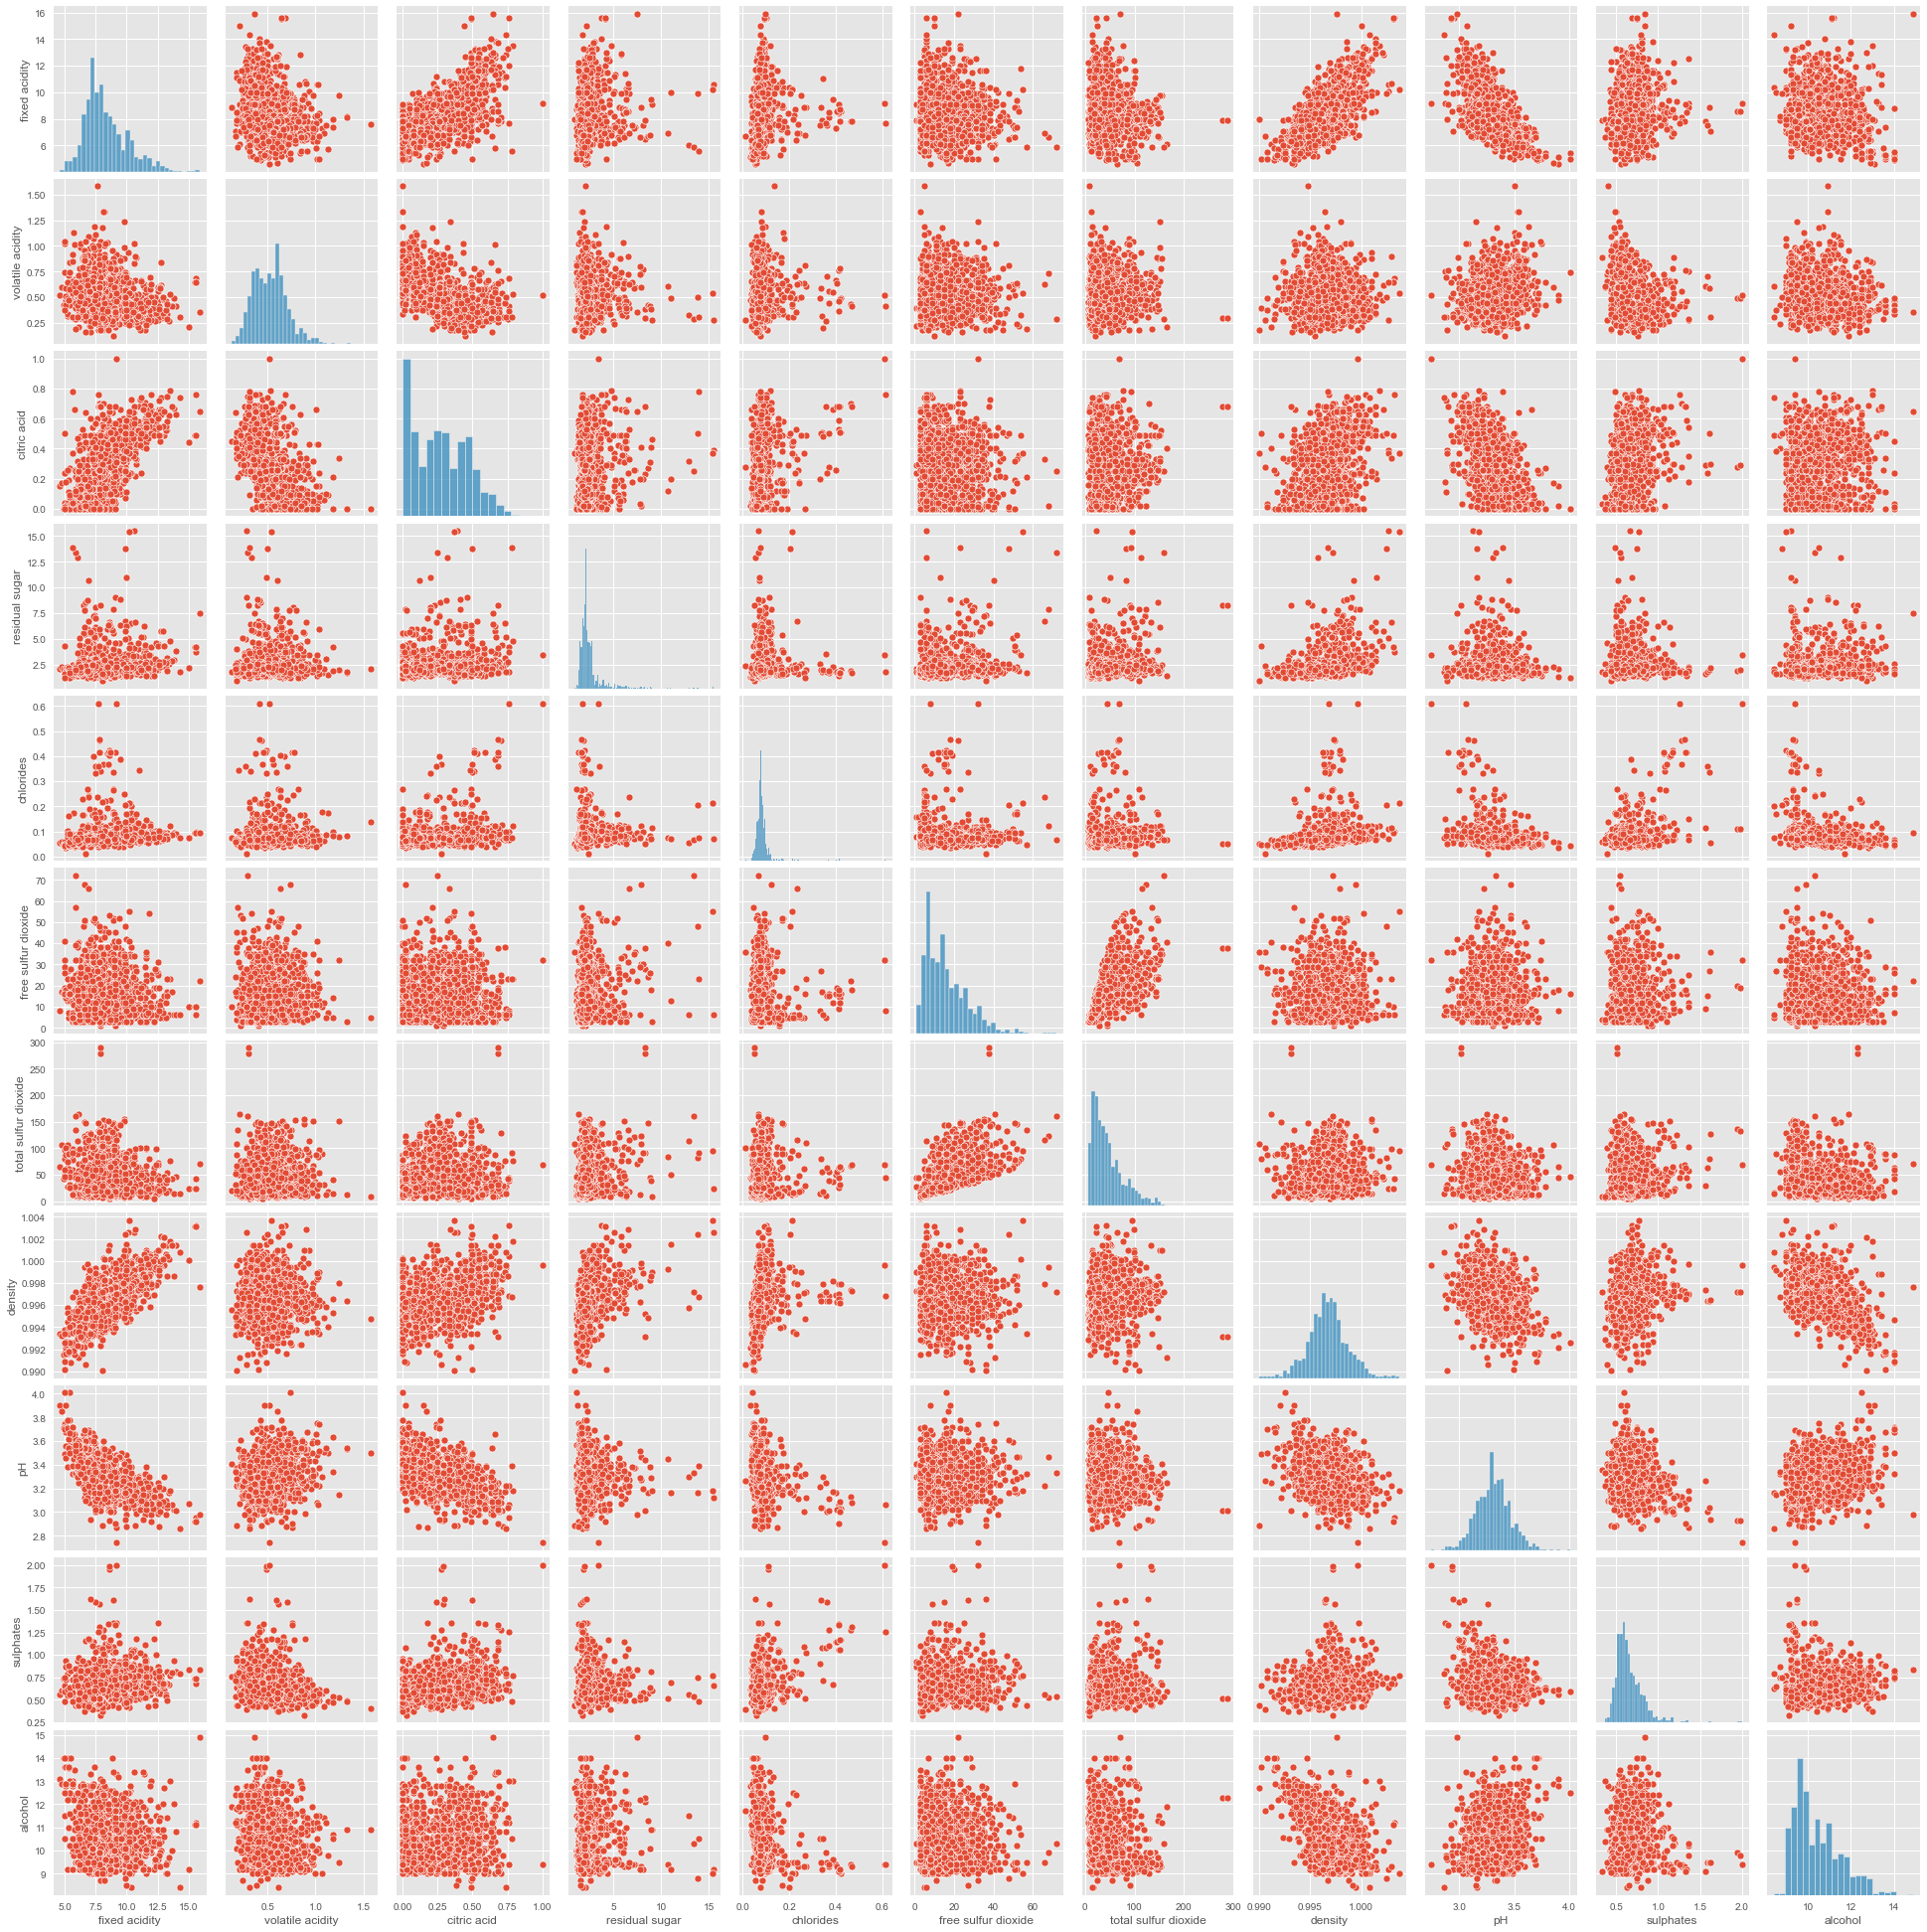

In [8]:
sns.pairplot(df.drop(['quality'], axis = 1))
plt.show()

# Insights on Outliers: Scatter Plots shows that most of the variables have outliers. Hence Outlier Treatment is necessary

In [9]:
# Outlier Treatment:
# Keep only those rows where the Z Score of all columns is < 3. 
# Basically drop all rows where Z Score value of at least 1 column >= 3

df=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

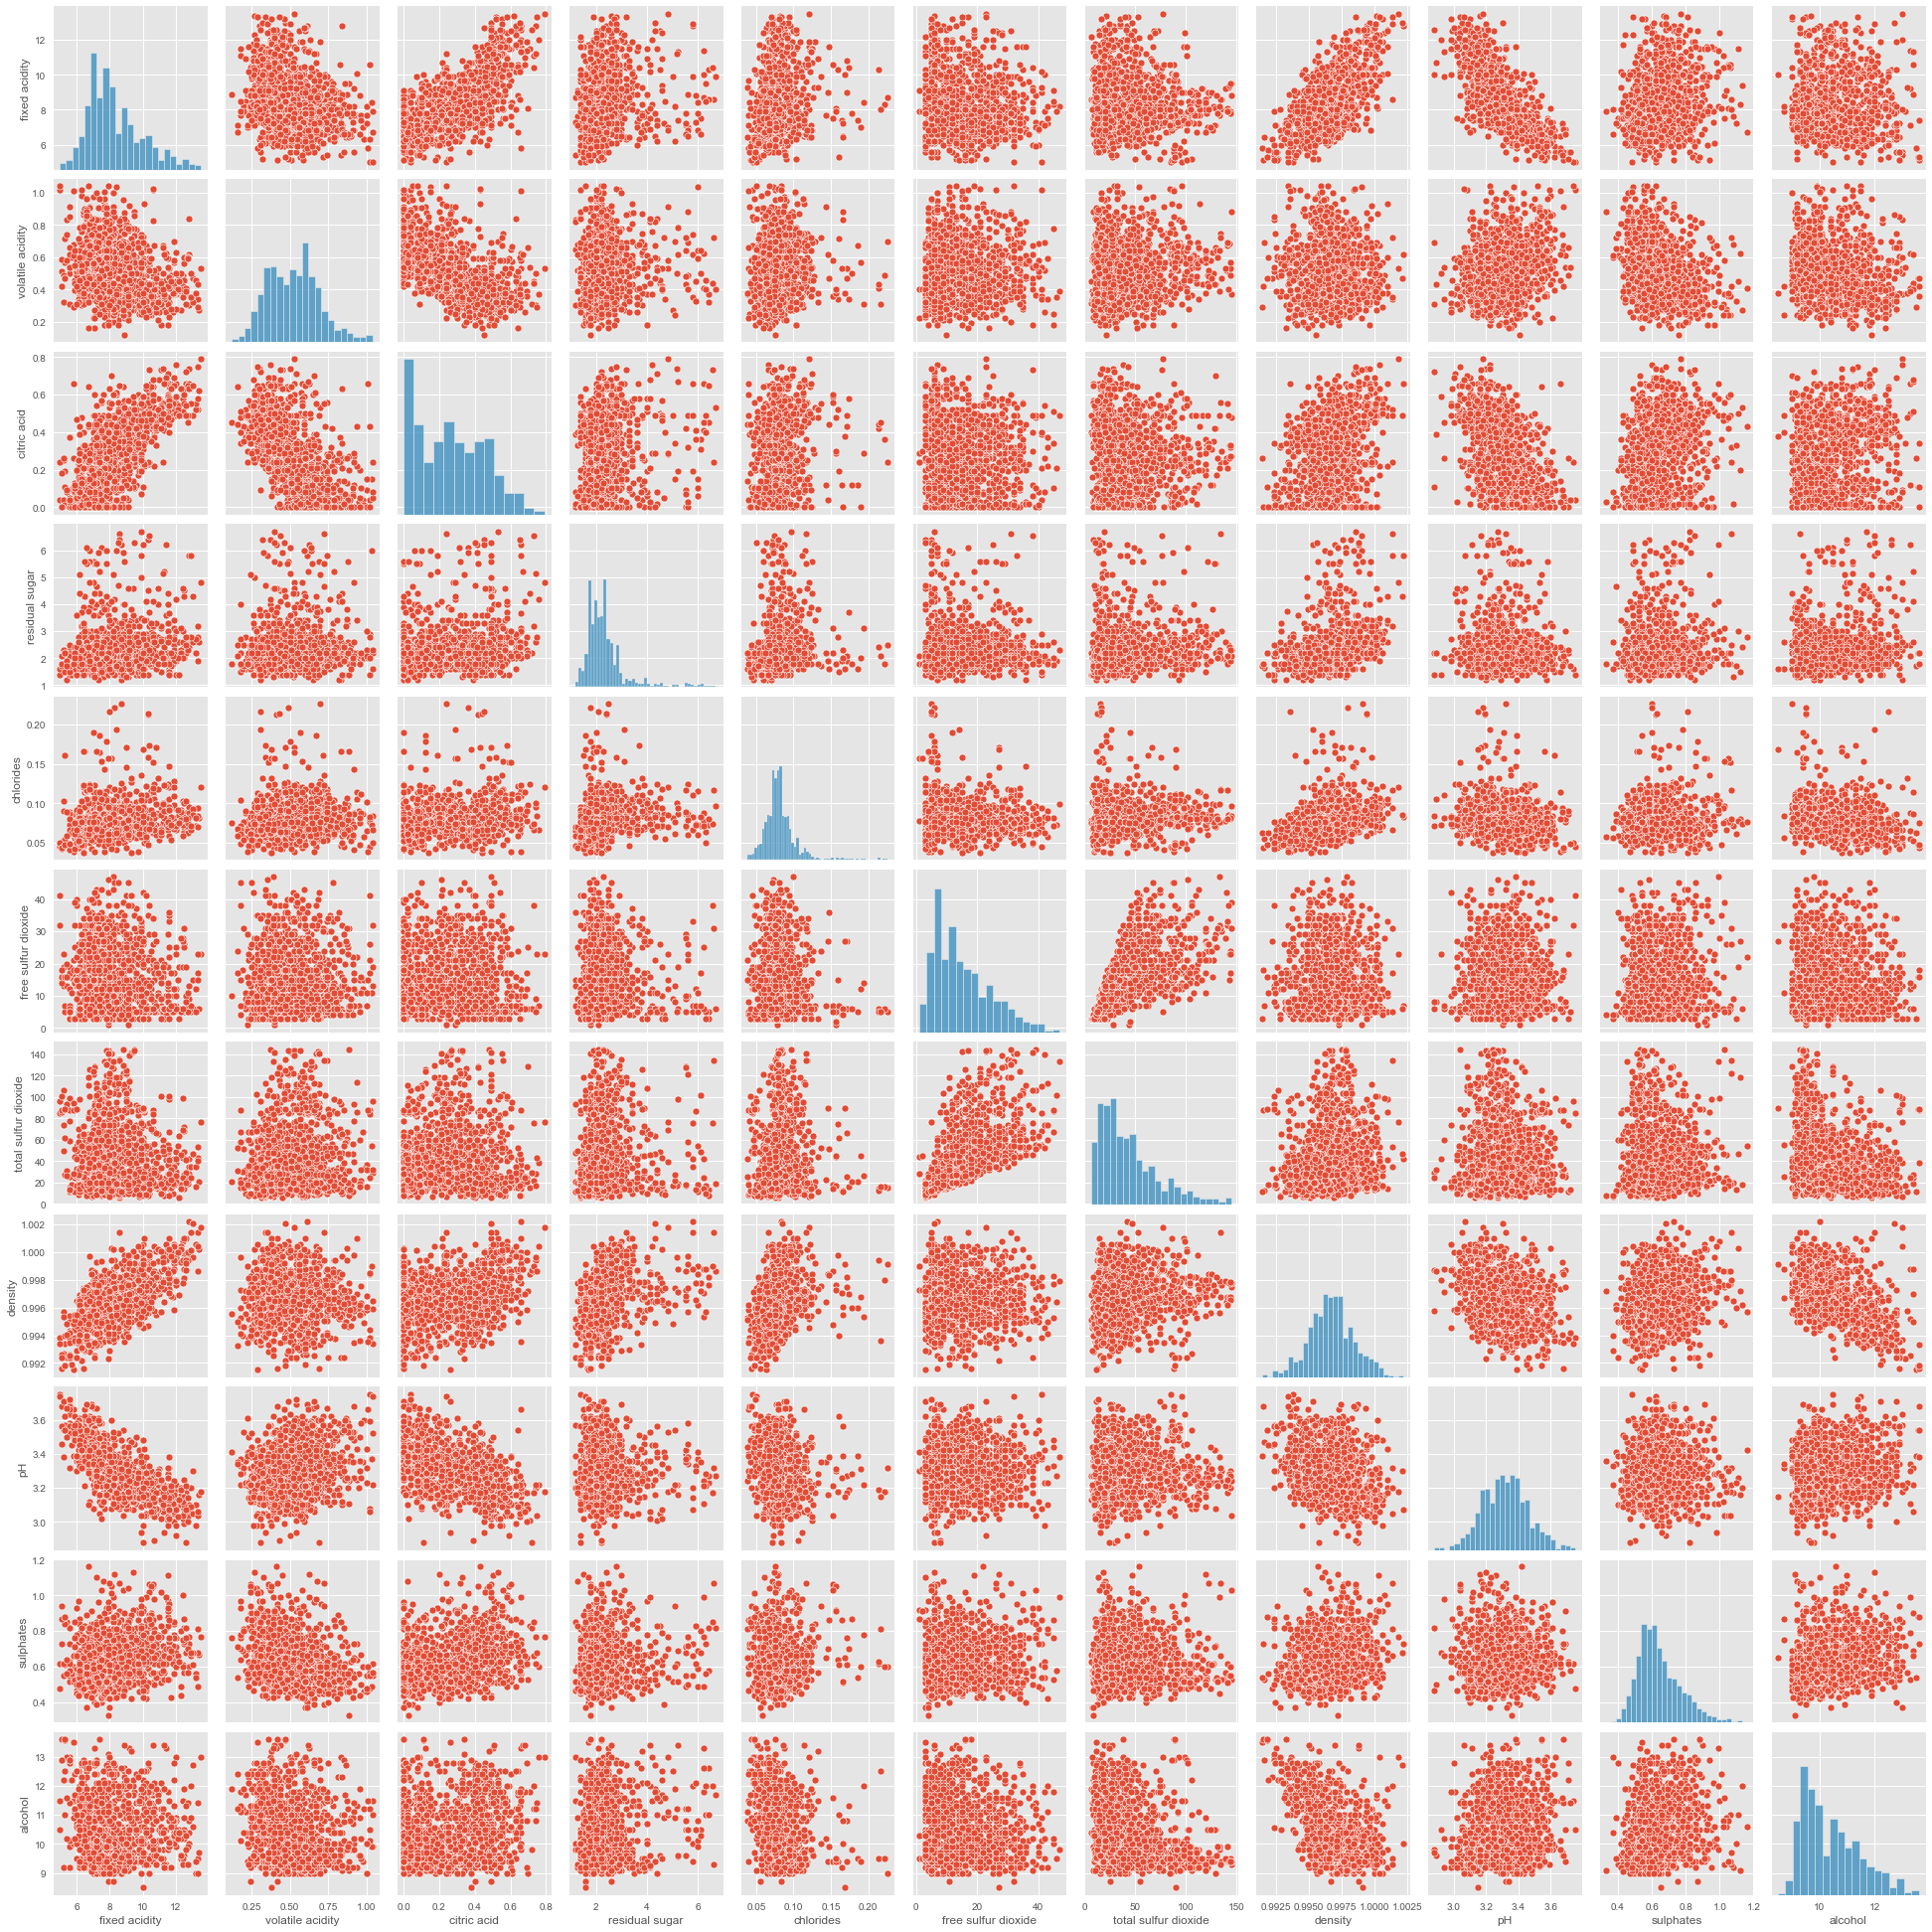

In [10]:
# Check for Outliers again after treating outliers
sns.pairplot(df.drop(['quality'], axis = 1))
plt.show()

# Insights: Outliers are significantly reduced now

In [11]:
# Double check the effect of Outlier Treatment by comparing Mean and Median
# If there is a high difference between mean and median, it may possibily due to the presence of outliers.
# Although there are other reasons as well like if the data is highly skewed at both ends.

col_list = list(df.columns)
median=df.median()
mean=df.mean()

for i in range(0, len(col_list)-1):
    print(col_list[i])
    print("Mean   = ", mean[i].round(1))
    print("Median = ", median[i].round(1), end = '\n\n')
    
# Insights: The gap between Mean and Median has reduced significantly

fixed acidity
Mean   =  8.3
Median =  7.9

volatile acidity
Mean   =  0.5
Median =  0.5

citric acid
Mean   =  0.3
Median =  0.2

residual sugar
Mean   =  2.4
Median =  2.2

chlorides
Mean   =  0.1
Median =  0.1

free sulfur dioxide
Mean   =  15.1
Median =  13.0

total sulfur dioxide
Mean   =  43.7
Median =  36.0

density
Mean   =  1.0
Median =  1.0

pH
Mean   =  3.3
Median =  3.3

sulphates
Mean   =  0.6
Median =  0.6

alcohol
Mean   =  10.4
Median =  10.2



# Plot Correlation Matrix to visualize the degree of Correlation between variables

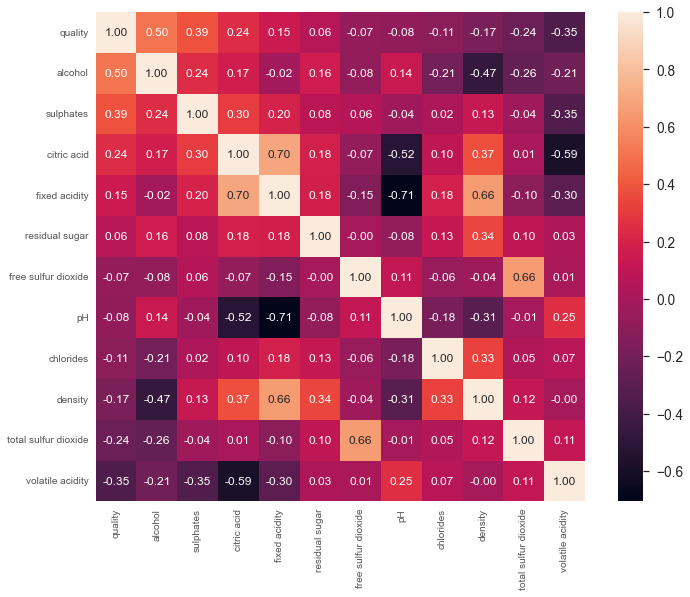

In [12]:
# Create Correlation Matrix
corrmat = df.corr()

# Correlation matrix
k = 12 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index

# Correlation Matrix
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Insights on Correlation: 'density', 'pH', 'fixed acidity', 'citric acid', 'alcohol' are moderately correlated
# Hence we calculate the VIF for these features

# Calculate VIF (Variance Inflation Factor)

In [13]:
# Calculate Variance Inflation Factor for all correlated variables

# the independent variables set
X = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

                 feature          VIF
0          fixed acidity    89.002451
1       volatile acidity    19.579511
2            citric acid     9.358017
3         residual sugar     9.927999
4              chlorides    18.125560
5    free sulfur dioxide     7.003640
6   total sulfur dioxide     6.956718
7                density  1696.645871
8                     pH  1242.149186
9              sulphates    31.740424
10               alcohol   141.935926


In [14]:
# Insights on Correlation and it's treatment: 
#        'fixed acidity', 'pH' and 'citric acid' are moderately correlated. Add these 3 columns to give one column 'pH'
#         and drop 'fixed acidity' and 'citric acid'
#        'free sulfur dioxide' and 'total sulfur dioxide' are moderately correlated. Subtract 'free sulfur dioxide' from
#        'total sulfur dioxide' and drop 'free sulfur dioxide'


df['pH'] = df['pH'] + df['fixed acidity'] + df['citric acid']
df['total sulfur dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

df = df.drop(['fixed acidity', 'free sulfur dioxide', 'citric acid', 'density'], axis = 1)

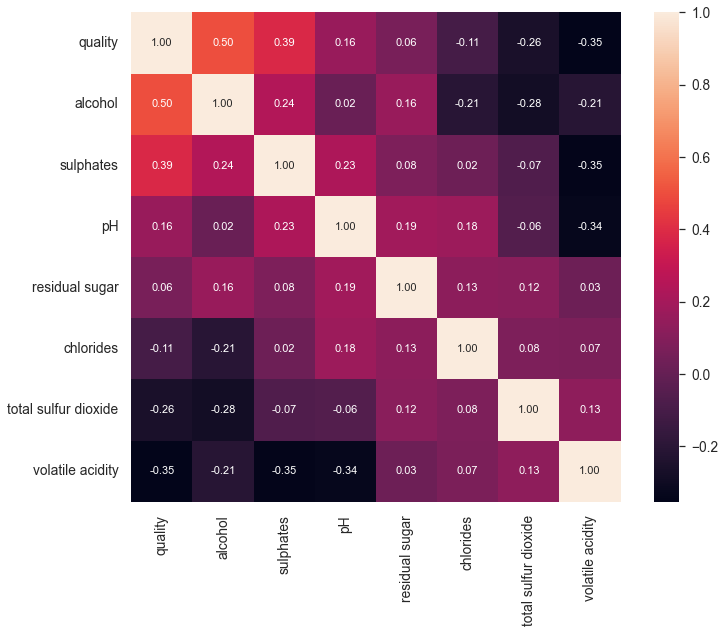

In [15]:
# Create Correlation Matrix again to check the effect of treatment

corrmat = df.corr()

# Correlation matrix
k = 11 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index

# Correlation Matrix
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [16]:
# Calculate Variance Inflation Factor for all correlated variables

# the independent variables set
X = df[['volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

# Insights: VIF Scores have reduced significantly

                feature        VIF
0      volatile acidity  10.350409
1        residual sugar   9.623865
2             chlorides  16.755527
3  total sulfur dioxide   2.504438
4                    pH  47.034063
5             sulphates  29.822505
6               alcohol  59.183213


# Convert the Target Column to Categorical

In [17]:
df['quality'] = pd.Categorical(df.quality)

In [18]:
encoded_df = df.copy(deep = True)
encoded_df_nb = encoded_df.copy(deep = True)

In [19]:
categories = dict(df['quality'].value_counts())
categories = list(categories.keys())
categories = sorted(categories, key=int, reverse=False)
categories = list(map(str, categories))
categories

['4', '5', '6', '7', '8']

# Feature Scaling / Standardization

In [20]:
# Save the Target Variable "quality" in variable y before standardization as Target Variable should not be standardised
y = encoded_df['quality'].values

In [21]:
cols = list(encoded_df.columns)
l = len(cols)-1
cols = cols[0:l]

#data = encoded_df.iloc[:, 1:].values  
data = encoded_df.drop('quality', axis = 1).values  

#standardize the data to normal distribution
dataset1_standardized = preprocessing.scale(data)
encoded_df1 = pd.DataFrame(dataset1_standardized, columns = cols)    # encoded_df1 is the dataset without the target variable
#encoded_df1.head(20)

In [22]:
# Save the standardised values of variables in x
x = encoded_df1.values

In [23]:
# Split Training and Testing Data in 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state = rdt)

In [24]:
# Final COlumns used for Model Building:

names = list(encoded_df.drop('quality', axis = 1).columns)
names_index = names[0:l]
names

['volatile acidity',
 'residual sugar',
 'chlorides',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol']

# Function to plot Confusion Matrix

In [25]:
# Function to plot Confusion Matrix. Callable in future from all models

def create_conf_mat(ytest, pred, model_name, mod):
    cm = confusion_matrix(y_test, pred, labels=[3,4,5,6,7,8])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[3,4,5,6,7,8])
    disp.plot(cmap='hot')
    plt.grid(False)
    plt.show()

# Classification Report

In [26]:
# Function to print Classification Report. Callable in future from all models

def print_class_report(predictions, y_t, target, alg_name):

    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, y_t, target_names = target))

# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Decision Tree Classifier

In [27]:
model_dt = DecisionTreeClassifier(random_state=rdt)

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [28]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# np.random.seed(rdt)
# start = time.time()

# param_dist = {'max_depth': [5, 6, 7, 8, 9, 10, 12],
#               'max_features': ['auto', 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy'],
#               'min_samples_split' : [3, 4, 5, 6, 7, 8, 9, 10, 12, 15],
#               'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]}

# # n_jobs should be 1 less than number of CPU cores. -1 means all cores
# cv_dt = GridSearchCV(model_dt, cv = 10, param_grid=param_dist, n_jobs = -1)                 

# cv_dt.fit(x_train, y_train)
# print('Best Parameters using grid search: \n', cv_dt.best_params_)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

# Decision Tree Classifier Model

In [29]:
# # Set best parameters given by grid search CV
# # model_dt.get_params().keys()

# for md in range(8,20):
#     for cri in ['gini', 'entropy']:
#         for mss in range(2,20):
#             for msl in range(2,15):
#                 for mf in ['auto', None]: 
#                     for ml in range(100,500,5):
#                         model_dt.set_params(max_depth=md, 
#                                             criterion=cri, 
#                                             min_samples_split=mss, 
#                                             min_samples_leaf=msl ,
#                                             max_features = mf,
#                                             max_leaf_nodes = ml)

#                         model_dt.fit(x_train, y_train)
#                         model_dt_score_train = model_dt.score(x_train, y_train)
#                         model_dt_score_test = model_dt.score(x_test, y_test)

#                         if model_dt_score_test >= 0.76:
#                             print("Accuracy = ", model_dt_score_test.round(4), md, cri, mss, msl, mf, ml)   

In [30]:
# Set best parameters given by grid search CV (Accuracy =  0.7251 13 gini 6 2)
model_dt.set_params(max_depth=10, 
                    criterion="gini", 
                    min_samples_split=6, 
                    min_samples_leaf=2 ,
                    max_features = 'auto',
                    max_leaf_nodes = 125)

model_dt.fit(x_train, y_train)

model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ", model_dt_score_train)

model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.7578544061302682
Testing score:  0.7671232876712328


# Plot the Decision Tree Structure

In [31]:
# df2 = pd.DataFrame(df.drop(['quality'], axis = 1))
# col_names = list(df2.columns)
# fn = col_names
# cn = ['4','5','6','7','8']

# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8), dpi = 300)
# tree.plot_tree(model_dt, feature_names = fn, class_names = cn, filled = True)
# fig.savefig('DecisionTree.jpg')

# Predictions & Evaluations (AUC, Confusion Matrix & Classification Report)

In [32]:
#predictions = model_dt.predict_proba(x_test)      # Predicts the probability of predictions being wither 0 or 1
y_pred_dt = model_dt.predict(x_test)             # Actual Predictions

In [33]:
accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt)
Precision_dt = metrics.precision_score(y_test, y_pred_dt,average='weighted')
recall_dt = metrics.recall_score(y_test, y_pred_dt,average='weighted')

print("Accuracy:",accuracy_dt)
print("Precision (Weighted Average):",Precision_dt)
print("Recall (Weighted Average):",recall_dt)

Accuracy: 0.7671232876712328
Precision (Weighted Average): 0.7505075822882594
Recall (Weighted Average): 0.7671232876712328


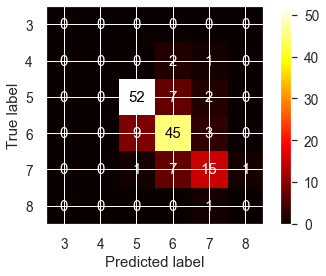

In [34]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test, y_pred_dt))
plot_confusion_matrix(model_dt, x_test, y_test, cmap='hot', labels=[3,4,5,6,7,8])

# Area Under Curve (AUC)

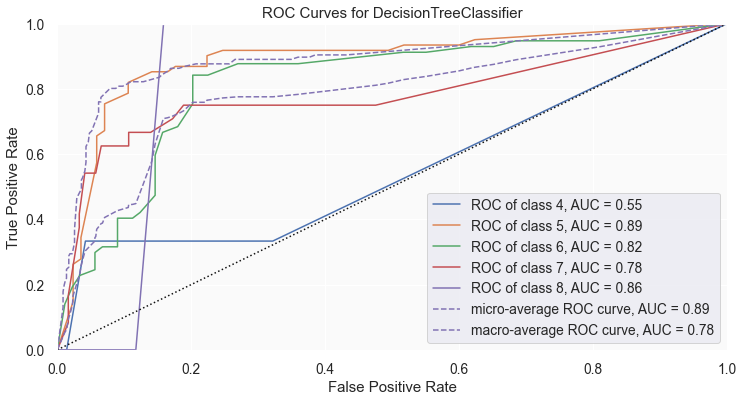

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')

visualizer = ROCAUC(model_dt, ax)

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
auc_dt = visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [36]:
# Print Classification Report:

class_report = print_class_report(y_pred_dt, y_test, categories, 'Decision Tree')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.85      0.84      0.85        62
           6       0.79      0.74      0.76        61
           7       0.62      0.68      0.65        22
           8       0.00      0.00      0.00         1

    accuracy                           0.77       146
   macro avg       0.45      0.45      0.45       146
weighted avg       0.79      0.77      0.78       146



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Random Forest Classifier Model

In [37]:
# Split the dataset for training and testing
x1 = encoded_df1.iloc[:, encoded_df1.columns != 'quality']
y1 = encoded_df.iloc[:, encoded_df.columns == 'quality']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.1, random_state = rrf)
# Cleaning test sets to avoid future warning messages
y_train1 = y_train1.values.ravel() 
y_test1 = y_test1.values.ravel() 

In [38]:
# Random Forest Classifier: Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=rrf)

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [39]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# np.random.seed(rrf)
# start = time.time()

# param_dist = {'max_depth': [6, 8, 10, 12, 13, 14, 15, 17, 18, 20],
#               'bootstrap': [True],
#               'max_features': ['auto', None],
#               'criterion': ['gini', 'entropy'],
#               'min_samples_split' : [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20],
#               'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18]}

# # Here we can add 'n_estimator' : [400, 500, 600], 'min_samples_split' : [5, 10, 15, 20], 'min_samples_leaf' : [2, 3, 4, 5] 
# # but that will consume lot of resources and increase computational time
# # Hence calculate OOB Error Rate and manually put the n_estimator value later
# # n_jobs should be 1 less than number of CPU cores. -1 means all cores
# cv_rf = GridSearchCV(fit_rf, cv = 5, param_grid=param_dist, n_jobs = -1)    

# cv_rf.fit(x_train1, y_train1)
# print('Best Parameters using grid search: \n', cv_rf.best_params_)
# print('Best Parameters using grid search: \n', cv_rf.get_params)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

# # Insight: Best Parameters: criterion='gini', max_depth=20, max_features='log2', min_samples_leaf=2, min_samples_split=5

# OOB (Out of Bag) Error Rate

In [40]:
# # OOB: Rows / Columns that are not included in a certain random sample. 
# # The model has no visibility to such records in that particular decision tree being created
# # as they are not exposed to that data

# fit_rf.set_params(warm_start=True, oob_score=True)
 
# min_estimators = 15
# max_estimators = 500
# error_rate = {}
# for i in range(min_estimators, max_estimators + 1):
#     fit_rf.set_params(n_estimators=i)
#     fit_rf.fit(x_train1, y_train1)
#     oob_error = 1 - fit_rf.oob_score_
#     error_rate[i] = oob_error
    
# # Convert dictionary to a pandas series for easy plotting 
# oob_series = pd.Series(error_rate)
# fig, ax = plt.subplots(figsize=(18, 8))
# ax.set_facecolor('#fafafa')
# oob_series.plot(kind='line',color = 'red')
# # plt.axhline(0.285, color='#875FDB',linestyle='--')
# # plt.axhline(0.295, color='#875FDB',linestyle='--')
# plt.xlabel('n_estimators')
# plt.ylabel('OOB Error Rate')
# plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1500 trees)')
    
# # Insights: Stable n_estimator is found to be around 800 from the OOB plot

In [41]:
# print('OOB Error rate for 380 trees is: {0:.5f}'.format(oob_series[250]))

In [42]:
# Best Parameters using grid search: 
#  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 7}
# Time taken in grid search:  8746.92

In [43]:
# # Set best parameters given by grid search CV

# temp = []

# for md in range(11,16):
#     for cri in ['entropy', 'gini']:
#         for mss in range(2,10):
#             for msl in range(2,10):
#                 for mf in ['auto', None]:    
#                     for ml in range(2,50,5):
#                         fit_rf.set_params(max_depth=md, 
#                                             criterion=cri, 
#                                             min_samples_split=mss, 
#                                             min_samples_leaf=msl, 
#                                             max_features = mf,
#                                             max_leaf_nodes = ml,
#                                             n_estimators=250,
#                                             bootstrap = True,
#                                             warm_start=False, 
#                                             oob_score=True)
                    
#                         # Train the Random Forest
#                         fit_rf.fit(x_train1, y_train1)

#                         model_rf_score_train = fit_rf.score(x_train1, y_train1)
#                         model_rf_score_test = fit_rf.score(x_test1, y_test1)

#                         tpl = (model_rf_score_test.round(4), md, cri, mss, msl, mf, ml)
#                         temp.append(tpl)

#                         if model_rf_score_test >= 0.81:
#                             print("Accuracy = ", model_rf_score_test.round(4), md, cri, mss, msl, mf, ml) 
                        
# temp

In [44]:
# Refine the tree via OOB Output for n_estimators
# n_estimators is the number of trees we want to build before taking the maximum voting or averages of predictions
# Set best parameters given by grid search 

fit_rf.set_params(max_depth=15, 
                  criterion="entropy", 
                  min_samples_split=2, 
                  min_samples_leaf=2,
                  max_leaf_nodes=495,
                  max_features = 'auto',
                  n_estimators=250,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=True)

# Train the Random Forest
fit_rf.fit(x_train1, y_train1)

model_rf_score_train = fit_rf.score(x_train1, y_train1)
print("Training score: ", model_rf_score_train)

model_rf_score_test = fit_rf.score(x_test1, y_test1)
print("Testing score: ",model_rf_score_test)

Training score:  0.9724137931034482
Testing score:  0.821917808219178


# Function to find Variable Importance

In [45]:
def variable_importance(fit):
    """
    Purpose:
    Checks if model is fitted CART model then produces variable importance and respective indices in dictionary.
    Parameters:
    * fit:  Fitted model containing the attribute feature_importances_
    Returns:
    Dictionary containing arrays with importance score and index of columns ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit))
        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")
    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances, 'index': indices}

In [46]:
var_imp_rf = variable_importance(fit_rf)
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']

# Check if the lengths of importances_rf, indices_rf, names_index are same. If not, there might be some error in names_index 
# earlier in the code
print("Length of importances_rf : ", len(importances_rf))
print("Length of indices_rf     : ", len(indices_rf))
print("Length of names_index    : ", len(names_index))

Length of importances_rf :  7
Length of indices_rf     :  7
Length of names_index    :  7


In [47]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose:
    Prints dependent variable names ordered from largest to smallest based on information gain for CART model.
    Parameters:
    * importance: Array returned from feature_importances_ for CART models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest based on feature_importances_
    * name_index: Name of columns included in model
    Returns:
    Prints feature importance in descending order
    """
    print("Feature ranking:")
    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}".format(f + 1,names_index[indices[i]],importance[indices[f]]))

In [48]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'alcohol' has a Mean Decrease in Impurity of 0.20542
2. The feature 'sulphates' has a Mean Decrease in Impurity of 0.16566
3. The feature 'volatile acidity' has a Mean Decrease in Impurity of 0.14285
4. The feature 'total sulfur dioxide' has a Mean Decrease in Impurity of 0.14243
5. The feature 'pH' has a Mean Decrease in Impurity of 0.12733
6. The feature 'chlorides' has a Mean Decrease in Impurity of 0.11803
7. The feature 'residual sugar' has a Mean Decrease in Impurity of 0.09830


In [49]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose:
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart was transposed and index would be in incorrect order.
    Parameters:
    * importance: Array returned from feature_importances_ for CART models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest based on feature_importances_
    * name_index: Name of columns included in model
    Returns:
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))
    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])
    fig, ax = plt.subplots(figsize=(10,8))
    #ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model')
    plt.barh(index, importance_desc, align="center", color = '#875FDB')
    plt.yticks(index, feature_space)

    plt.ylim(-1, l)                 # Limit should be from -1 to the length of the dataset (i.e. number of dependent variables)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')
    plt.show()

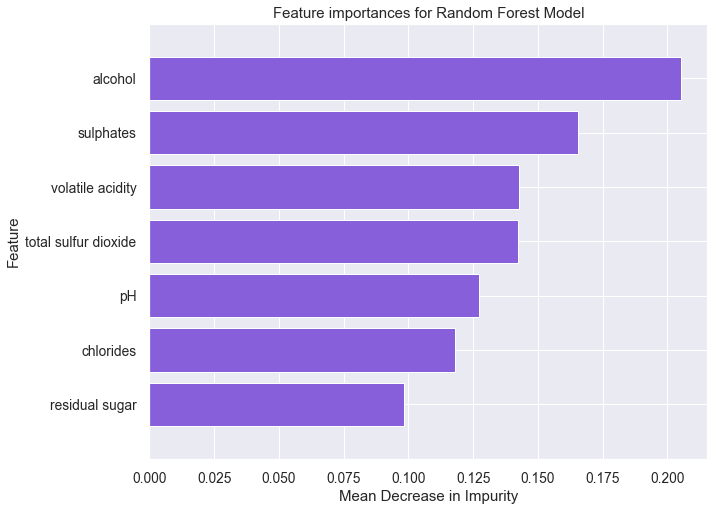

In [50]:
# Most important variables contributing to the Target Variable in descending order of their importance
# The same observations are noticed in EDA as well
variable_importance_plot(importances_rf, indices_rf, names_index)

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [51]:
y_pred_rf = fit_rf.predict(x_test1)

In [52]:
accuracy_rf = metrics.accuracy_score(y_test1, y_pred_rf)
Precision_rf = metrics.precision_score(y_test1, y_pred_rf,average='weighted')
recall_rf = metrics.recall_score(y_test1, y_pred_rf,average='weighted')

print("Accuracy:",accuracy_rf)
print("Precision (Weighted Average):",Precision_rf)
print("Recall (Weighted Average):",recall_rf)

Accuracy: 0.821917808219178
Precision (Weighted Average): 0.8000699701594168
Recall (Weighted Average): 0.821917808219178


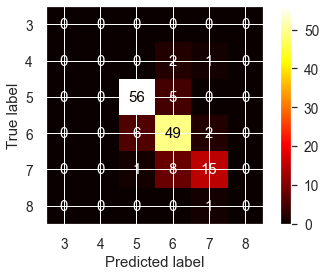

In [53]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test1, y_pred_rf))
plot_confusion_matrix(fit_rf, x_test1, y_test1, cmap='hot', labels=[3,4,5,6,7,8])

# Accuracy & Error Rate

In [54]:
model_rf_score_train = fit_rf.score(x_train1, y_train1)
print("Training score: ", model_rf_score_train)

model_rf_score_test = fit_rf.score(x_test1, y_test1)
print("Testing score: ",model_rf_score_test)

Training score:  0.9724137931034482
Testing score:  0.821917808219178


# Area Under Curve (AUC)

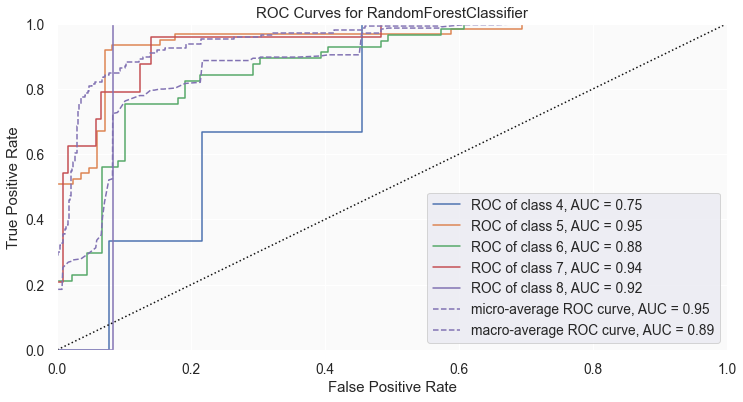

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [55]:
# Plot AUC

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')
visualizer = ROCAUC(fit_rf, ax)
visualizer.fit(x_train1, y_train1)        # Fit the training data to the visualizer
auc_rf = visualizer.score(x_test1, y_test1)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [56]:
# Call functiont to print Classification Report
class_report = print_class_report(y_pred_rf, y_test1, categories, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.92      0.89      0.90        63
           6       0.86      0.77      0.81        64
           7       0.62      0.79      0.70        19
           8       0.00      0.00      0.00         0

    accuracy                           0.82       146
   macro avg       0.48      0.49      0.48       146
weighted avg       0.85      0.82      0.84       146



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# K Nearest Neighbor (KNN)

In [57]:
# Split the dataset for training and testing
x2 = encoded_df1.iloc[:, encoded_df1.columns != 'quality']
y2 = encoded_df.iloc[:, encoded_df.columns == 'quality']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.2, random_state = rknn)
# Cleaning test sets to avoid future warning messages
y_train2 = y_train2.values.ravel() 
y_test2 = y_test2.values.ravel() 

In [58]:
knn = KNeighborsClassifier()

# Detection of Optimal Value for K Neighnours

In [59]:
# error = []

# # Calculating error for K values between 1 and 40
# for i in range(1, 50):  
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(x_train2, y_train2)
#     pred_i = knn.predict(x_test2)
#     error.append(np.mean(pred_i != y_test2))
    
# plt.figure(figsize=(12, 6))  
# plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
# plt.title('Error Rate K Value')  
# plt.xlabel('K Value')  
# plt.ylabel('Mean Error')  
# plt.show()

# # Insights: The value of K for highest accuracy is 19

In [60]:
# # Another way to plot n_neighbors:

# err = []

# # Calculating error for K values between 1 and 40
# for i in range(1, 100):  
#     knn = KNeighborsClassifier(n_neighbors=i)
#     score = cross_val_score(knn, x_train2, y_train2, cv = 10)
#     err.append(1-score.mean())
    
# plt.figure(figsize=(12, 6))  
# plt.plot(range(1, 100), err, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
# plt.title('Error Rate K Value')  
# plt.xlabel('K Value')  
# plt.ylabel('Mean Error')  
# plt.show()

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [61]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards

k_range = list(range(2, 100))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1, n_jobs = -1)

# fitting the model for grid search
grid_search=grid.fit(x_train2, y_train2)

print(grid_search.best_params_)

accuracy = grid_search.best_score_*100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 98 candidates, totalling 980 fits
{'n_neighbors': 40}
Accuracy for our training dataset with tuning is : 60.43%


# K-Nearest Neighbours Classifier

In [62]:
# In the Detection of Optimal Value for K Neighnours plot, 40 shows stable result

classifier = KNeighborsClassifier(n_neighbors=19)
classifier.fit(x_train2, y_train2)  

KNeighborsClassifier(n_neighbors=19)

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [63]:
y_pred_knn = classifier.predict(x_test2)  

In [64]:
accuracy_knn = metrics.accuracy_score(y_test2, y_pred_knn)
Precision_knn = metrics.precision_score(y_test2, y_pred_knn,average='weighted')
recall_knn = metrics.recall_score(y_test2, y_pred_knn,average='weighted')

print("Accuracy:",accuracy_knn)
print("Precision (Weighted Average):",Precision_knn)
print("Recall (Weighted Average):",recall_knn)

Accuracy: 0.6735395189003437
Precision (Weighted Average): 0.660795101301319
Recall (Weighted Average): 0.6735395189003437


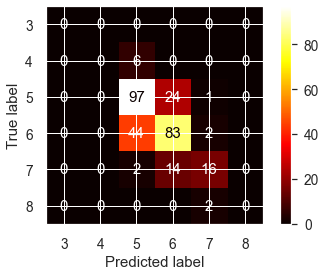

In [65]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test2, y_pred_knn))
plot_confusion_matrix(classifier, x_test2, y_test2, cmap='hot', labels=[3,4,5,6,7,8])

# Accuracy and Error Rate

In [66]:
model_knn_score_train = classifier.score(x_train2, y_train2)
print("Training score: ", model_knn_score_train)

model_knn_score_test = classifier.score(x_test2, y_test2)
print("Testing score: ",model_knn_score_test)

Training score:  0.6422413793103449
Testing score:  0.6735395189003437


# Area Under Curve (AUC)

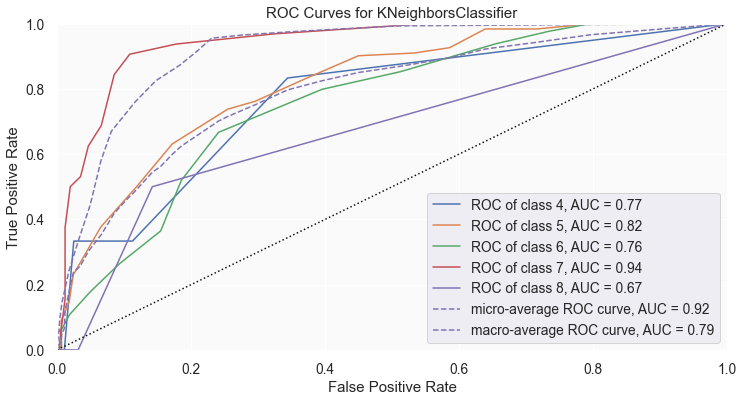

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')

visualizer = ROCAUC(classifier, ax)

visualizer.fit(x_train2, y_train2)        # Fit the training data to the visualizer
auc_knn = visualizer.score(x_test2, y_test2)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [68]:
# Print Classification Report:

class_report = print_class_report(y_pred_knn, y_test2, categories, 'K Nearest Neighbor')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for K Nearest Neighbor:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.80      0.65      0.72       149
           6       0.64      0.69      0.66       121
           7       0.50      0.76      0.60        21
           8       0.00      0.00      0.00         0

    accuracy                           0.67       291
   macro avg       0.39      0.42      0.40       291
weighted avg       0.71      0.67      0.69       291



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Support Vector Machines (SVM)

In [69]:
# Split the dataset for training and testing
x3 = encoded_df1.iloc[:, encoded_df1.columns != 'quality']
y3 = encoded_df.iloc[:, encoded_df.columns == 'quality']
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size = 0.2, random_state = rsvm)
# Cleaning test sets to avoid future warning messages
y_train3 = y_train3.values.ravel() 
y_test3 = y_test3.values.ravel() 

# Kernel Parameter

In [70]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Linear Kernel:
# svc=SVC(kernel='linear')
# svc.fit(x_train3,y_train3)
# y_pred_svm=svc.predict(x_test3)
# print('\nAccuracy Score for Linear Kernel: ', metrics.accuracy_score(y_test3,y_pred_svm))

# # Polynomial Kernel:
# svc=SVC(kernel='poly')
# svc.fit(x_train3,y_train3)
# y_pred_svm=svc.predict(x_test3)
# print('Accuracy Score for Polynomial Kernel: ', metrics.accuracy_score(y_test3,y_pred_svm))

# # rbf Kernel:
# svc=SVC(kernel='rbf')
# svc.fit(x_train3,y_train3)
# y_pred_svm=svc.predict(x_test3)
# print('Accuracy Score for rbf Kernel: ', metrics.accuracy_score(y_test3,y_pred_svm))

# # sigmoid Kernel:
# svc=SVC(kernel='sigmoid')
# svc.fit(x_train3,y_train3)
# y_pred_svm=svc.predict(x_test3)
# print('Accuracy Score for sigmoid Kernel: ', metrics.accuracy_score(y_test3,y_pred_svm))

# # Insights: 'rbf' kernel gives the best accuracy

# Optimizing Hyper Parameter C

In [71]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Optimizing the HyperParameter C

# C_range=list(range(1,40))
# acc_score=[]
# for c in C_range:
#     svc = SVC(kernel='rbf', C=c)
#     scores = cross_val_score(svc, x3, y3, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# print(acc_score)
# ind = acc_score.index(max(acc_score))
# print("\nOptimal Integer Value of C =", C_range[ind])

# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
# C_values=list(range(1,40))
# plt.plot(C_values,acc_score)
# plt.xticks(np.arange(0,42,4))
# plt.xlabel('Value of C for SVC')
# plt.ylabel('Cross-Validated Accuracy')

In [72]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Find the exact value of C up to 1 place of decimal

# C_range=list(np.arange(0, 2, 0.05))
# acc_score=[]
# for c in C_range:
#     svc = SVC(kernel='rbf', C=c)
#     scores = cross_val_score(svc, x, y, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# #print(acc_score)    
# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
# C_values=list(np.arange(0, 2, 0.05))
# plt.figure(figsize = (20,6))
# plt.plot(C_values,acc_score)
# plt.xticks(np.arange(0,2,0.1))
# plt.xlabel('Value of C for SVC ')
# plt.ylabel('Cross-Validated Accuracy')

# # Insights: Optimal value of C - Hyperparameter is: 1.3

# Optimizing Hyper Parameter Gamma

In [73]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Optimizing the HyperParameter Gamma

# gamma_range=[0.0001, 0.001, 0.01, 0.1, 0.5, 1]
# acc_score=[]
# for g in gamma_range:
#     svc = SVC(kernel='rbf', gamma=g)
#     scores = cross_val_score(svc, x3, y3, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# print(acc_score)  
# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
# gamma_range=[0.0001, 0.001, 0.01, 0.1, 0.5, 1]
# plt.figure(figsize = (20,6))
# plt.plot(gamma_range,acc_score)
# plt.xlabel('Value of gamma for SVC ')
# plt.xticks(np.arange(0,1,0.05))
# plt.ylabel('Cross-Validated Accuracy')

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [74]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# svm_model= SVC()
# tuned_parameters = {'C': (np.arange(0,1,0.05)), 
#                     'gamma': [0.09, 0.095, 0.10, 0.105, 0.11], 
#                     'kernel':['rbf'], 
#                     'degree': [1, 2, 3, 4]}

# fit_svm = GridSearchCV(svm_model, tuned_parameters, cv=10, scoring='accuracy', n_jobs = -1)
# fit_svm.fit(x_train3, y_train3)
# print("Accuracy: ", fit_svm.best_score_)
# print("Parameters: ", fit_svm.best_params_)

# Support Vector Machine (SVM) Classifier

In [75]:
svm_model= SVC(probability=True)
tuned_parameters = {'C': [0.65] , 'kernel': ['rbf'], 'gamma': [0.11], 'degree': [1]}

fit_svm = GridSearchCV(svm_model, tuned_parameters, cv=10, scoring='accuracy', n_jobs = -1)
fit_svm.fit(x_train3, y_train3)
print("Accuracy: ", fit_svm.best_score_)
print("Parameters: ", fit_svm.best_params_)

Accuracy:  0.6129310344827588
Parameters:  {'C': 0.65, 'degree': 1, 'gamma': 0.11, 'kernel': 'rbf'}


# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [76]:
y_pred_svm = fit_svm.predict(x_test3)

In [77]:
accuracy_svm = metrics.accuracy_score(y_test3, y_pred_svm)
Precision_svm = metrics.precision_score(y_test3, y_pred_svm,average='weighted')
recall_svm = metrics.recall_score(y_test3, y_pred_svm,average='weighted')

print("Accuracy:",accuracy_svm)
print("Precision (Weighted Average):",Precision_svm)
print("Recall (Weighted Average):",recall_svm)

Accuracy: 0.7044673539518901
Precision (Weighted Average): 0.6818561313683434
Recall (Weighted Average): 0.7044673539518901


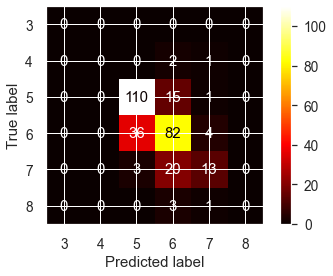

In [78]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test3, y_pred_svm))
plot_confusion_matrix(fit_svm, x_test3, y_test3, cmap='hot', labels=[3,4,5,6,7,8])

# Accuracy and Error Rate

In [79]:
model_svm_score_train = fit_svm.score(x_train3, y_train3)
print("Training score: ", model_svm_score_train)

model_svm_score_test = fit_svm.score(x_test3, y_test3)
print("Testing score: ",model_svm_score_test)

Training score:  0.6327586206896552
Testing score:  0.7044673539518901


# Area Under Curve (AUC)

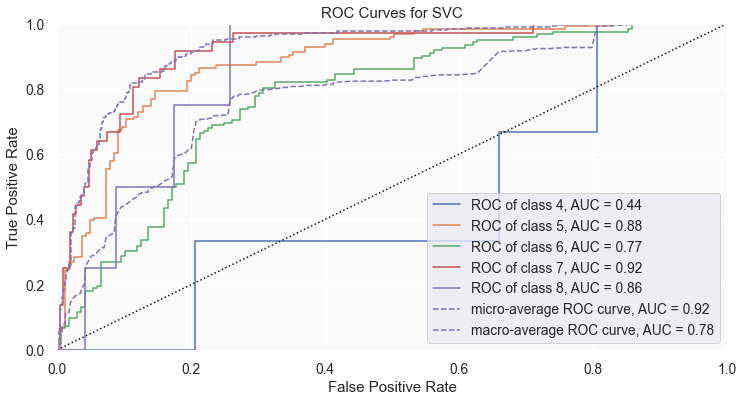

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')
visualizer = ROCAUC(svm_model, ax)
visualizer.fit(x_train3, y_train3)        # Fit the training data to the visualizer
auc_svm = visualizer.score(x_test3, y_test3)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [81]:
# Print Classification Report:

class_report = print_class_report(y_pred_svm, y_test3, categories, 'Support Vector Machines')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Support Vector Machines:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.87      0.74      0.80       149
           6       0.67      0.67      0.67       122
           7       0.36      0.65      0.46        20
           8       0.00      0.00      0.00         0

    accuracy                           0.70       291
   macro avg       0.38      0.41      0.39       291
weighted avg       0.75      0.70      0.72       291



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Logistic Regression Classifier

In [82]:
# Split the dataset for training and testing
x4 = encoded_df1.iloc[:, encoded_df1.columns != 'quality']
y4 = encoded_df.iloc[:, encoded_df.columns == 'quality']
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size = 0.1, random_state = rlr)
# Cleaning test sets to avoid future warning messages
y_train4 = y_train4.values.ravel() 
y_test4 = y_test4.values.ravel() 

In [83]:
logreg = LogisticRegression()

In [84]:
# Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

cv_logreg = GridSearchCV(logreg, cv=10, n_jobs=-1, param_grid = grid)
cv_logreg.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",cv_logreg.best_params_)
print("accuracy :",cv_logreg.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.5938285378743393


In [85]:
logreg2=LogisticRegression(C=0.01,penalty="l2")

In [86]:
logreg2.fit(x_train4,y_train4)

LogisticRegression(C=0.01)

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [87]:
y_pred_log=logreg2.predict(x_test4)

In [88]:
accuracy_log = metrics.accuracy_score(y_test4, y_pred_log)
Precision_log = metrics.precision_score(y_test4, y_pred_log,average='weighted')
recall_log = metrics.recall_score(y_test4, y_pred_log,average='weighted')

print("Accuracy:",accuracy_log)
print("Precision (Weighted Average):",Precision_log)
print("Recall (Weighted Average):",recall_log)

Accuracy: 0.6917808219178082
Precision (Weighted Average): 0.6819152574453756
Recall (Weighted Average): 0.6917808219178082


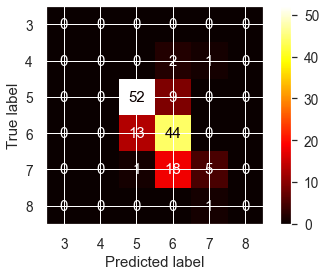

In [89]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test4, y_pred_log))
plot_confusion_matrix(logreg2, x_test4, y_test4, cmap='hot', labels=[3,4,5,6,7,8])

# Accuracy & Error Rate

In [90]:
model_lr_score_train = logreg2.score(x_train4, y_train4)
print("Training score: ", model_lr_score_train)

model_lr_score_test = logreg2.score(x_test4, y_test4)
print("Testing score: ",model_lr_score_test)

Training score:  0.5961685823754789
Testing score:  0.6917808219178082


# Area Under Curve (AUC)

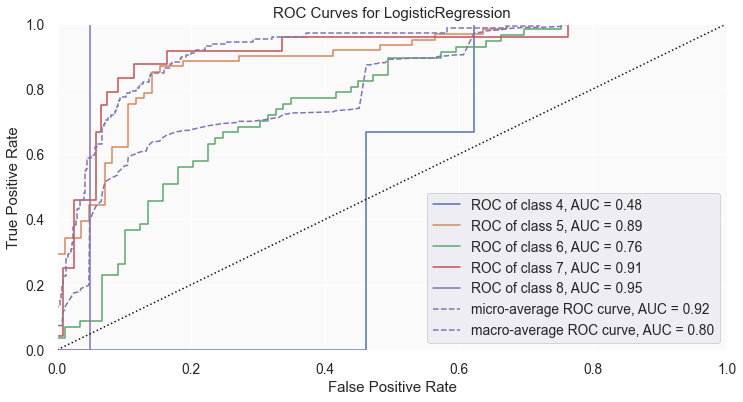

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')
visualizer = ROCAUC(logreg, ax)
visualizer.fit(x_train4, y_train4)        # Fit the training data to the visualizer
auc_lr = visualizer.score(x_test4, y_test4)       # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [92]:
# Print Classification Report:

class_report = print_class_report(y_pred_log, y_test4, categories, 'Logistic Regression')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.85      0.79      0.82        66
           6       0.77      0.60      0.68        73
           7       0.21      0.71      0.32         7
           8       0.00      0.00      0.00         0

    accuracy                           0.69       146
   macro avg       0.37      0.42      0.36       146
weighted avg       0.78      0.69      0.72       146



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Multinomial Naive Bayes Classifier

In [93]:
xNB = encoded_df_nb.iloc[:, encoded_df_nb.columns != 'quality']
yNB = encoded_df_nb.iloc[:, encoded_df_nb.columns == 'quality']
X_trainNB, X_testNB, y_trainNB, y_testNB = train_test_split(xNB, yNB, test_size=0.2, random_state=rnb)
# Cleaning test sets to avoid future warning messages
y_trainNB = y_trainNB.values.ravel() 
y_testNB = y_testNB.values.ravel() 

In [94]:
nb = MultinomialNB()
nb.fit(X_trainNB, y_trainNB)
model_nb_score_train1 = nb.score(X_trainNB, y_trainNB)
print("Training score: ", model_nb_score_train1)

model_nb_score_test1 = nb.score(X_testNB, y_testNB)
print("Testing score: ",model_nb_score_test1)

y_pred_nb = nb.predict(X_testNB)

Training score:  0.4017241379310345
Testing score:  0.4536082474226804


# Accuracy and Error Rate

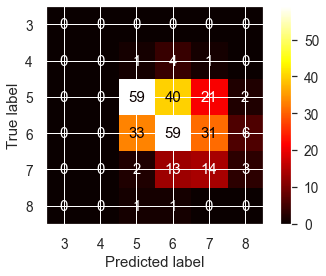

In [95]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_testNB, y_pred_nb, labels=[3,4,5,6,7,8]))
plot_confusion_matrix(nb, X_testNB, y_testNB, cmap='hot', labels=[3,4,5,6,7,8])

In [96]:
# Print Classification Report:

class_report = print_class_report(y_pred_nb, y_testNB, categories, 'Naive Bayes Classifier')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.48      0.61      0.54        96
           6       0.46      0.50      0.48       117
           7       0.44      0.21      0.28        67
           8       0.00      0.00      0.00        11

    accuracy                           0.45       291
   macro avg       0.28      0.27      0.26       291
weighted avg       0.44      0.45      0.44       291



# Area Under Curve (AUC)

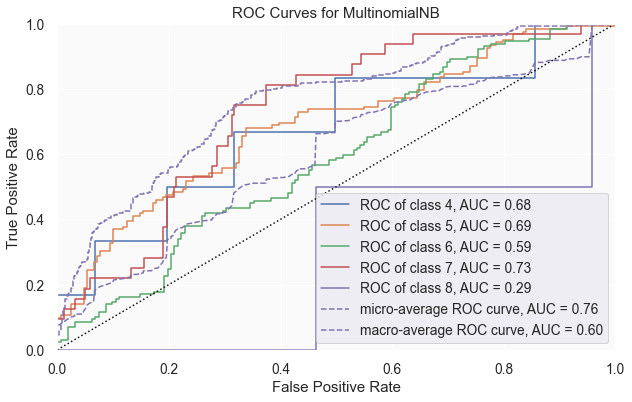

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#fafafa')
visualizer = ROCAUC(nb, ax)
visualizer.fit(X_trainNB, y_trainNB)        # Fit the training data to the visualizer
auc_nb1 = visualizer.score(X_testNB, y_testNB)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

# Gaussian Naive Bayes Classifier

In [98]:
# Gaussian Naive Bayes

gnb = GaussianNB()
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

nbModel_grid = GridSearchCV(gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_trainNB, y_trainNB)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=1.873817422860383e-05)


# Accuracy and Error Rate

In [99]:
y_pred_nb2 = nbModel_grid.predict(X_testNB)

model_nb_score_train2 = nbModel_grid.score(X_trainNB, y_trainNB)
print("Training score: ", model_nb_score_train2)

model_nb_score_test2 = nbModel_grid.score(X_testNB, y_testNB)
print("Testing score: ",model_nb_score_test2)

Training score:  0.5939655172413794
Testing score:  0.6632302405498282


In [100]:
accuracy_nb = metrics.accuracy_score(y_testNB, y_pred_nb2)
Precision_nb = metrics.precision_score(y_testNB, y_pred_nb2,average='weighted')
recall_nb = metrics.recall_score(y_testNB, y_pred_nb2,average='weighted')

print("Accuracy:",accuracy_nb)
print("Precision (Weighted Average):",Precision_nb)
print("Recall (Weighted Average):",recall_nb)

Accuracy: 0.6632302405498282
Precision (Weighted Average): 0.6567311976752231
Recall (Weighted Average): 0.6632302405498282


In [101]:
# Print Classification Report:
class_report = print_class_report(y_pred_nb2, y_testNB, categories, 'Naive Bayes Classifier')

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

           4       0.17      1.00      0.29         1
           5       0.84      0.68      0.75       149
           6       0.63      0.65      0.64       125
           7       0.28      0.56      0.38        16
           8       0.00      0.00      0.00         0

    accuracy                           0.66       291
   macro avg       0.38      0.58      0.41       291
weighted avg       0.71      0.66      0.68       291



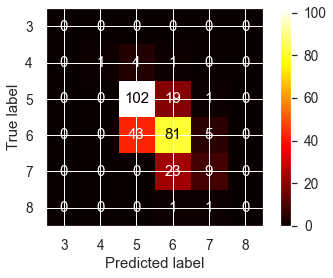

In [102]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_testNB, y_pred_nb2))
plot_confusion_matrix(nbModel_grid, X_testNB, y_testNB, cmap='hot', labels=[3,4,5,6,7,8])

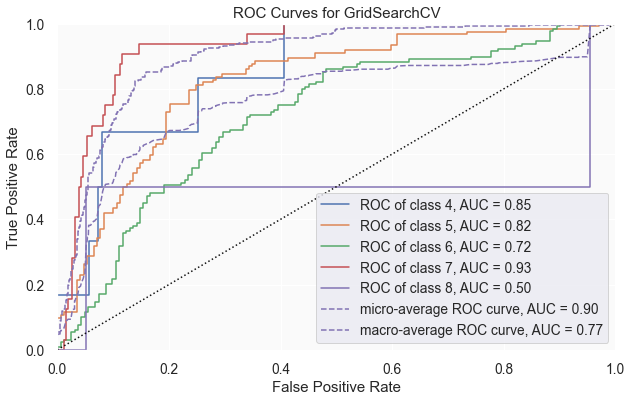

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#fafafa')
visualizer = ROCAUC(nbModel_grid, ax)
visualizer.fit(X_trainNB, y_trainNB)        # Fit the training data to the visualizer
auc_nb2 = visualizer.score(X_testNB, y_testNB)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [104]:
# # BernoulliNB

# nb = BernoulliNB()

# params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
#          }

# bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
# bernoulli_nb_grid.fit(xNB,yNB)

# print('Train Accuracy : %.3f'%bernoulli_nb_grid.best_estimator_.score(X_trainNB, y_trainNB))
# print('Test Accuracy : %.3f'%bernoulli_nb_grid.best_estimator_.score(X_testNB, y_testNB))
# print('Best Accuracy Through Grid Search : %.3f'%bernoulli_nb_grid.best_score_)
# print('Best Parameters : ',bernoulli_nb_grid.best_params_)

# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Final Model Comparison:

# Confusion Matrix Comparison Between Models

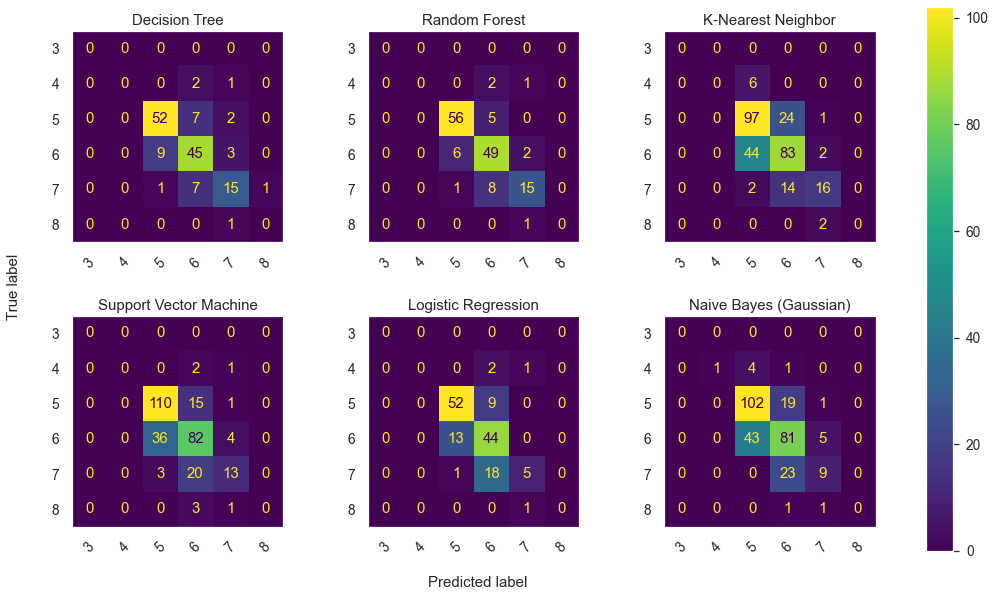

In [105]:
test = [y_test, y_test1, y_test2, y_test3, y_test4, y_testNB]
pred = [y_pred_dt, y_pred_rf, y_pred_knn, y_pred_svm, y_pred_log, y_pred_nb2]
model = ["Decision Tree", "Random Forest", "K-Nearest Neighbor", "Support Vector Machine", "Logistic Regression", "Naive Bayes (Gaussian)"]
plot_grid = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
plt.rcParams["axes.grid"] = False
f, axes = plt.subplots(2, 3, figsize=(18, 10))

for cr in range(len(test)):    
    cm = confusion_matrix(test[cr], pred[cr], labels=[3,4,5,6,7,8])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[3,4,5,6,7,8])
    if cr<3:
        disp.plot(ax=axes[0, cr], xticks_rotation=45)
    else:
        disp.plot(ax=axes[1, (cr-3)], xticks_rotation=45)
    disp.ax_.set_title(model[cr])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')    
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.075, 'Predicted label', ha='left')
f.text(0.075, 0.45, 'True label', ha='left', rotation = 90)
plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# Precision, Accuracy and AUC Comparison Between Models

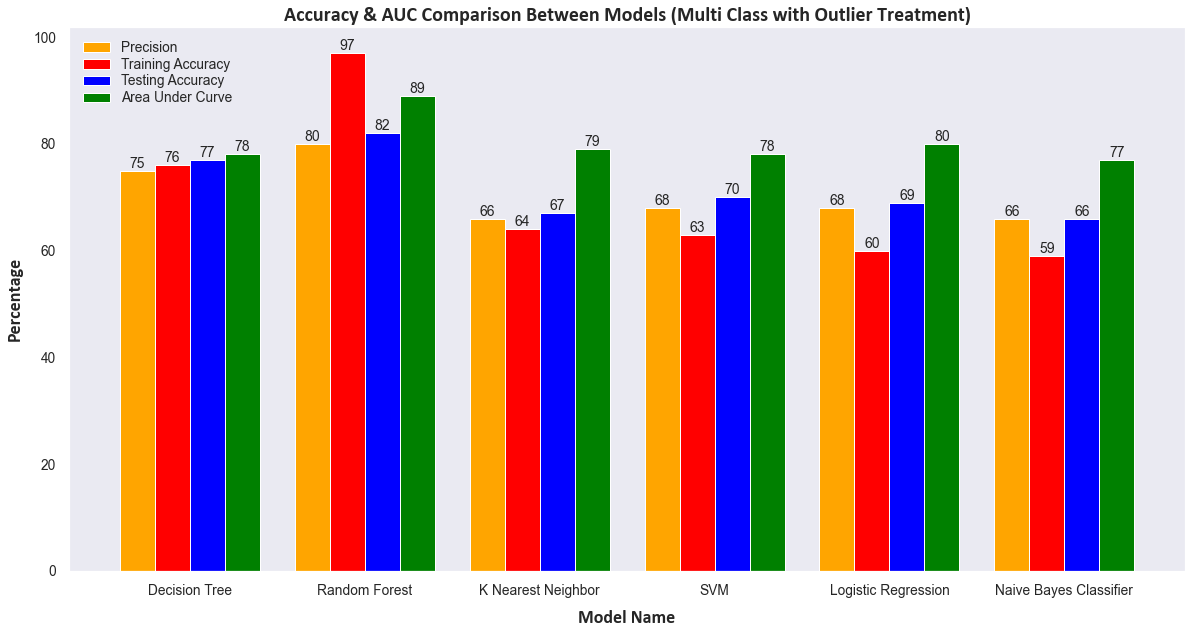

In [106]:
# Create a list of tuples with Mean Test Accuracy of all models:
acc_comparison_test = [('Decision Tree', (model_dt_score_test*100).round()), 
                  ('Random Forest', (model_rf_score_test*100).round()), 
                  ('K Nearest Neighbor', (model_knn_score_test*100).round()), 
                  ('SVM', (model_svm_score_test*100).round()), 
                  ('Logistic Regression', (model_lr_score_test*100).round()),
                  ('Naive Bayes Classifier', (model_nb_score_test2*100).round())]

# Sort the above list of tuples in descending order of Accuracy:
#acc_comparison.sort(key = lambda x: x[1], reverse = True)
acc_comparison_test = dict(acc_comparison_test)

# Create a list of tuples with Mean Train Accuracy of all models:
acc_comparison_train = [('Decision Tree', (model_dt_score_train*100).round()), 
                  ('Random Forest', (model_rf_score_train*100).round()), 
                  ('K Nearest Neighbor', (model_knn_score_train*100).round()), 
                  ('SVM', (model_svm_score_train*100).round()), 
                  ('Logistic Regression', (model_lr_score_train*100).round()),
                  ('Naive Bayes Classifier', (model_nb_score_train2*100).round())]

# Sort the above list of tuples in descending order of Accuracy:
#acc_comparison.sort(key = lambda x: x[1], reverse = True)
acc_comparison_train = dict(acc_comparison_train)

# Create a list of tuples with Area Under Curve of all models:
auc_comparison = [('Decision Tree', (auc_dt*100).round()), 
                  ('Random Forest', (auc_rf*100).round()), 
                  ('K Nearest Neighbor', (auc_knn*100).round()), 
                  ('SVM', (auc_svm*100).round()), 
                  ('Logistic Regression', (auc_lr*100).round()),
                  ('Naive Bayes Classifier', (auc_nb2*100).round())]

# Sort the above list of tuples in descending order of AUC:
#auc_comparison.sort(key = lambda x: x[1], reverse = True)
auc_comparison = dict(auc_comparison)

# Create a list of tuples with Area Under Curve of all models:
prc_comparison = [('Decision Tree', (Precision_dt*100).round()), 
                  ('Random Forest', (Precision_rf*100).round()), 
                  ('K Nearest Neighbor', (Precision_knn*100).round()), 
                  ('SVM', (Precision_svm*100).round()), 
                  ('Logistic Regression', (Precision_log*100).round()),
                  ('Naive Bayes Classifier', (Precision_nb*100).round())]

# Sort the above list of tuples in descending order of AUC:
#auc_comparison.sort(key = lambda x: x[1], reverse = True)
prc_comparison = dict(prc_comparison)

# Plot a bar graph to compare the result
fig = plt.figure(figsize = (20,10))
X_axis = np.arange(len(acc_comparison_test.keys()))  

plt.bar(X_axis - 0.3, prc_comparison.values(), 0.2, color = "Orange", label = "Precision")
plt.bar(X_axis - 0.1, acc_comparison_train.values(), 0.2, color = "Red", label = "Training Accuracy")
plt.bar(X_axis + 0.1, acc_comparison_test.values(), 0.2, color = "Blue", label = "Testing Accuracy")
plt.bar(X_axis + 0.3, auc_comparison.values(), 0.2, color = "Green", label = "Area Under Curve")

# Add Labels
plt.xticks(X_axis, acc_comparison_train.keys())
plt.title("Accuracy & AUC Comparison Between Models (Multi Class with Outlier Treatment)", fontsize=20, fontweight='bold', fontname='calibri')
plt.xlabel("Model Name", fontsize=18, labelpad=12, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage", fontsize=18, labelpad=10, fontweight='bold', fontname='calibri')

lst1 = list(acc_comparison_train.values())
lst2 = list(acc_comparison_test.values())
model_lst = list(acc_comparison_train.keys())
lst3 = list(auc_comparison.values())
lst4 = list(prc_comparison.values())

# Annotate the bars with values
for i in range(len(lst1)):
    plt.annotate(int(lst4[i]), xy=(i-0.3, lst4[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst1[i]), xy=(i-0.1, lst1[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst2[i]), xy=(i+0.1, lst2[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst3[i]), xy=(i+0.3, lst3[i]), ha='center', va='bottom', fontsize = 14)
    
# Add Legend    
plt.legend(loc='upper left', borderpad=1, borderaxespad=0, labelspacing=0.2)

# Insights: SVM consistently produces the highest Accuracy and AUC with the least difference between Accuracy and AUC, 
# followed by Random Forest and K-nn

# Final Summary of Insights

# Binary Classification V/S Multi Class Classification - Which one is better?

In [107]:
# In binary class, it doesn't matter if 3 is classified as 4 or if 4 is classified as 6 
# as both 4 and 6 are less than 7, which means 'BAD WINE', so it's classified correctly. 

# However in Multi Class, if 3 is classified as 4 or if 4 is classified as 6, it means misclassification 
# and hence accuracy is low. 

# Also, having more classes in the Target Variable reduces the sample size for each class
# and hence training data size is smaller

# To conclude, more the number of classes in the target variable, lower the accuracy

# Best Model

In [108]:
# Random Forest consistently produces the highest Accuracy and AUC, 
# followed by KNN, Decision Tree, SVM, Logistic Reg and Naive Bayes.

# However difference between Training and Testing accuracies is quite high for all models except Decision Tree and KNN

# In case of Decision Tree, Precision, Training Accuracy, Testing Accuracy and AUC are very close to each other 
# and hence the MOST PREFERRED algorithm in this case